In [1]:
!pip install -q git+https://github.com/NiklasHoltmeyer/FashionNets.git

     |████████████████████████████████| 954 kB 7.7 MB/s 
     |████████████████████████████████| 631 kB 56.5 MB/s 
     |████████████████████████████████| 138 kB 65.9 MB/s 
     |████████████████████████████████| 356 kB 70.6 MB/s 
     |████████████████████████████████| 138 kB 59.5 MB/s 
     |████████████████████████████████| 138 kB 71.0 MB/s 
     |████████████████████████████████| 153 kB 67.0 MB/s 
     |████████████████████████████████| 137 kB 71.1 MB/s 
     |████████████████████████████████| 136 kB 75.8 MB/s 
     |████████████████████████████████| 136 kB 58.7 MB/s 
     |████████████████████████████████| 136 kB 73.6 MB/s 
     |████████████████████████████████| 53 kB 2.6 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 48 kB 4.5 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 40 kB 7.0 MB/s 
     |████████████████████████████████| 354 kB 52.3 MB/s 
     |███████████████████

In [2]:
#@title Build Triplets
from collections import defaultdict
from tensorflow.keras.datasets.mnist import load_data
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

(x_train_val, y_train_val), (x_test, y_test) = load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

# 2 Channel to 3 Channel 

one_chanel_to_3_channel = lambda grey: cv2.merge((grey,grey,grey))
resize_image = lambda i: cv2.resize(i, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
channel_and_resize = lambda i: resize_image(one_chanel_to_3_channel(i))

x_train_val = list(map(channel_and_resize, x_train_val))
x_test = list(map(channel_and_resize, x_test))



def group_images_by_class():
    by_class = defaultdict(lambda: [])

    for idx, (image, label) in enumerate(zip(x_train_val, y_train_val)):
        by_class[label].append((idx, image))
        
    return by_class

def random_class_ids(list_of_ids):
    random_anchor_positive_class_id = random.sample(list_of_ids, 1)[0]
    
    while True:
        negative_class_id = random.sample(list_of_ids, 1)[0]
        if negative_class_id != random_anchor_positive_class_id:
            return random_anchor_positive_class_id, negative_class_id
        
def build_triplets(n_items=50):
    by_class = group_images_by_class()
    list_of_ids = by_class.keys()
    
    for _ in range(n_items):
        positive_class_id, negative_class_id = random_class_ids(list_of_ids)
        assert positive_class_id != negative_class_id

        (a_idx, a_img), (p_idx, p_img) = random.sample(by_class[positive_class_id], 2)
        assert a_idx != p_idx

        n_idx, n_img = random.sample(by_class[negative_class_id], 1)[0]

        assert n_idx != a_idx != p_idx
        
        yield a_img, p_img, n_img

def visualize(anchors, positive, negatives):
    n_samples = min(len(anchors), 5)
    
    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(n_samples, 3)
    for i in range(n_samples):
        show(axs[i, 0], anchors[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negatives[i])    

11501568/11490434 [==============================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

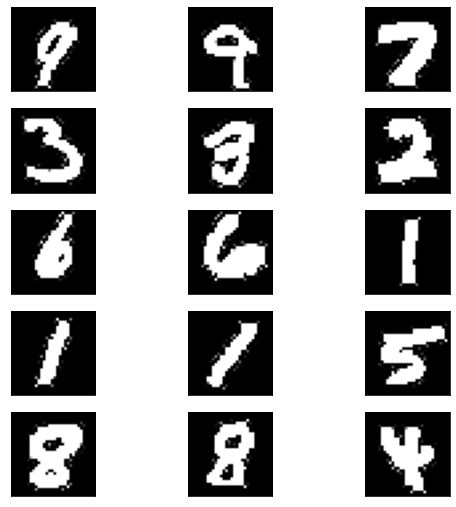

In [3]:
#@title Build Dataset

apns = list(build_triplets())
anchors, positves, negatives = [x[0] for x in apns], [x[1] for x in apns], [x[2] for x in apns]

a_ds, p_ds, n_ds = tf.data.Dataset.from_tensor_slices(anchors), tf.data.Dataset.from_tensor_slices(positves), tf.data.Dataset.from_tensor_slices(negatives)

apn_ds =  tf.data.Dataset.zip((a_ds, p_ds, n_ds))
apn_ds = apn_ds.batch(32).prefetch(tf.data.AUTOTUNE)

visualize(anchors, positves, negatives)

In [4]:
#@title Build Back_Bone
from fashionnets.models.layer.ResNetIdentityBlock import ResnetIdentityBlock
from tensorflow.keras.applications import resnet
from tensorflow.keras.regularizers import l2
from tensorflow.python.keras.models import Sequential
from fashionnets.networks.SiameseNetwork import SiameseNetwork
from fashionnets.models.SiameseModel import SiameseModel
from tensorflow.keras.optimizers import Adam

weights = "imagenet" # 'imagenet' 
input_shape = x_train_val[0].shape
embedding_dim = 256

R = resnet.ResNet50(
    weights=weights, input_shape=input_shape, include_top=False
)

back_bone = Sequential([R,
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
        kernel_initializer='he_uniform', padding='same',
        kernel_regularizer=l2(2e-4)),
        ResnetIdentityBlock(3, [64, 64, 256]),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(embedding_dim, activation=None, use_bias=False)
])

94781440/94765736 [==============================] - 1s 0us/step


In [5]:
#@title Build Model
preprocess_input = resnet.preprocess_input
siamese_network = SiameseNetwork(back_bone, is_triplet=True, alpha=1.0, beta=None, input_shape=input_shape[:2], preprocess_input=preprocess_input)

siamese_model = SiameseModel(siamese_network, back_bone)
siamese_model.compile(Adam(1e-4))

apn_ds_small = apn_ds.take(1)

In [6]:
siamese_model.fit(apn_ds, epochs=100)

Epoch 1/100
2/2 [==============================] - 28s 445ms/step - loss: 4.5001
Epoch 2/100
2/2 [==============================] - 0s 98ms/step - loss: 0.5480
Epoch 3/100
2/2 [==============================] - 0s 97ms/step - loss: 0.1110
Epoch 4/100
2/2 [==============================] - 0s 100ms/step - loss: 0.0597
Epoch 5/100
2/2 [==============================] - 0s 96ms/step - loss: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0535
Epoch 7/100
2/2 [==============================] - 0s 102ms/step - loss: 0.0065
Epoch 8/100
2/2 [==============================] - 0s 98ms/step - loss: 0.0141
Epoch 9/100
2/2 [==============================] - 0s 96ms/step - loss: 0.0089
Epoch 10/100
2/2 [==============================] - 0s 96ms/step - loss: 0.0299
Epoch 11/100
2/2 [==============================] - 0s 97ms/step - loss: 0.0000e+00
Epoch 12/100
2/2 [==============================] - 0s 103ms/step - loss: 0.0000e+00
Epoch 13/100
2/2 [==============

KeyboardInterrupt: ignored